<a href="https://colab.research.google.com/github/jarayl/SkinCheck/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General Python/ML libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Specific ML models/packages
from tensorflow.keras.models import Model
from tensorflow.keras.saving import load_model
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K
from tensorflow import GradientTape

In [ ]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Checkpoint filepath and saved model weights
densenet169_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/densenet169' # best model/optimized for classification
resnet50v2_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/resnet50v2' # best model/optimized for Grad-CAM

# Dataset directory
# test_dir = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/binary/test'

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Image-related parameters
CHANNELS = 3
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
RESNET50V2_IMG_WIDTH, RESNET50V2_IMG_HEIGHT = 300, 300
DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT = 224, 224
TARGET_SIZE = (DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT)
INPUT_SHAPE = (DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT, CHANNELS)

PERCENTAGE_FACTOR = 100;
PERCENT_CONFIDENCE_TRUNCATION = 5
CLASS_THRESHOLD = 0.5
GRAD_CAM_INTENSITY_MULTIPLIER = 180

PLT_SETTINGS = {'family': 'DejaVu Sans',
                'weight': 'heavy',
                'size'  :  11}

CLASSES = ['benign', 'malignant']

In [24]:
# testing_data_gen = ImageDataGenerator(rescale=1./255)

In [23]:
# test_gen = testing_data_gen.flow_from_directory(test_dir,
#                                                 color_mode=COLOR_MODE,
#                                                 target_size=TARGET_SIZE,
#                                                 class_mode='binary',
#                                                 batch_size=BATCH_SIZE,
#                                                 shuffle=False)

In [20]:
def grad_CAM(model, img, intensity_factor):
    with GradientTape() as tape:
        # ResNet-50V2 had the most accurate/precise visualizations for Grad-CAM
        last_conv_layer = model.get_layer('conv5_block3_out') # find last convolutional layer from the network (where filters/activations are strongest)
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img.reshape(1, RESNET50V2_IMG_WIDTH, RESNET50V2_IMG_HEIGHT, CHANNELS))
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # Determine areas of strong activation
    heatmap = np.maximum(heatmap, 0) # intensify "hot regions"
    np.seterr(divide='ignore', invalid='ignore')
    heatmap /= np.max(heatmap) # Constrain pixel range [0, 1]
    heatmap = heatmap.reshape(10, 10) # condense heatmap

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    colormap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_JET)

    dimmed_heatmap = colormap * intensity_factor
    superimposed_img = ((dimmed_heatmap + img) * GRAD_CAM_INTENSITY_MULTIPLIER).astype(np.uint8) # overlay heatmap on top of original image

    return superimposed_img

In [14]:
def make_inference(diagnosis_model, grad_cam_model, img_array):
    densenet_resized_img = np.asarray(resize(img_array, TARGET_SIZE)).astype(np.uint8)
    np.seterr(divide='ignore', invalid='ignore')
    densenet_resized_img = densenet_resized_img / 255

    testing_img = densenet_resized_img.reshape(1, DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT, CHANNELS)
    prediction = diagnosis_model.predict(testing_img)[0][0]

    # Benign diagnosis
    if prediction < CLASS_THRESHOLD:
        network_prediction = CLASSES[0]
        network_percent_confidence = str((1 - prediction) * PERCENTAGE_FACTOR)[:PERCENT_CONFIDENCE_TRUNCATION]

    # Malignant diagnosis
    else:
        network_prediction = CLASSES[1]
        network_percent_confidence = str(prediction * PERCENTAGE_FACTOR)[:PERCENT_CONFIDENCE_TRUNCATION]

    grad_cam_resized_img = np.asarray(resize(densenet_resized_img, (RESNET50V2_IMG_WIDTH, RESNET50V2_IMG_HEIGHT)))
    superimposed_img = grad_CAM(model=grad_cam_model, img=grad_cam_resized_img, intensity_factor=0.0015)

    # Convert grad_cam_resized_img back into a standard image (with pixel values ranging from 0 - 255)
    grad_cam_resized_img = grad_cam_resized_img * 255
    return grad_cam_resized_img, superimposed_img, network_prediction, network_percent_confidence

In [15]:
diagnosis_model = load_model(densenet169_model_filepath)
grad_cam_model = load_model(resnet50v2_model_filepath)

1/1 [==============================] - 0s 195ms/step


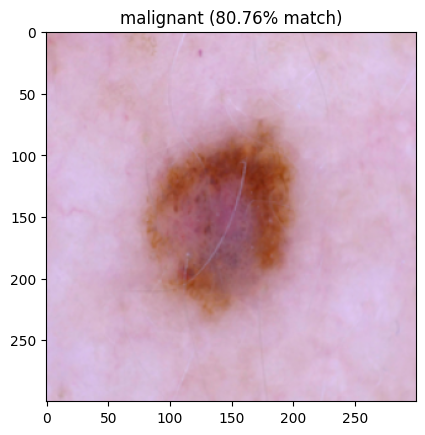

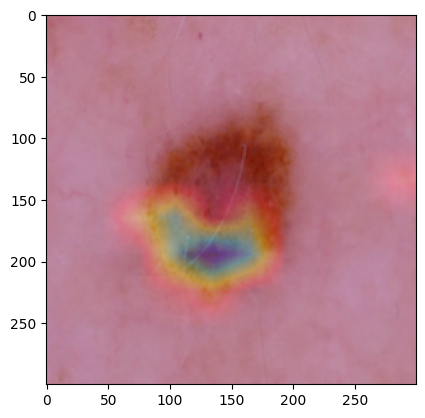

In [25]:
#@title Sample Diagnostic Test in Colab {run: "auto", vertical-output: true}

# batch = test_gen.next()
# image_batch = batch[0]
# batch_labels = batch[1]

# 32 represents the batch size
# image_index = 16 #@param {type:"slider", min:1, max:32, step:1}
# testing_image = (image_batch[image_index - 1] * 255).astype(np.uint8)

# true_label = int(batch_labels[image_index - 1])
# print('True Label:', CLASSES[true_label])

# ----------------------------------------------

test_img_fp = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/malignant_samples/1065.jpg'
testing_image = cv2.imread(test_img_fp).astype(np.uint8)
# cv2 (OpenCV) uses BGR whereas Matplotlib uses RGB, need to convert back into RGB so image displays properly
testing_image = cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB)

grad_cam_resized_img, superimposed_img, network_prediction, network_percent_confidence = make_inference(diagnosis_model=diagnosis_model, grad_cam_model=grad_cam_model, img_array=testing_image)
plt.imshow(grad_cam_resized_img/255) # need to divide by 255 for matplotlib but not for the actual webapp display
plt.title(f'{network_prediction} ({network_percent_confidence}% match)')
plt.show()
plt.imshow(superimposed_img)
plt.show()